# 12,000 Circles

Author - Calum Armstrong

The work in this notebook is based on the artwork created by Hamid Naderi Yeganeh.

The original work can be found at https://blogs.scientificamerican.com/guest-blog/making-mathematical-art/.

This notebook features the design from the above source entitled 12,000 circles.

This design is a hardware accelerated model designed to be run on the PYNQ-Z2 board.

Firstly, import the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import math


The values that will be recieved back via the AXI4-Lite interface from the PYNQ-Z2 board will be 32 bits in length.
Python recognises these as 32 bit unsigned numbers.
The following function is used to convert these to signed binary numbers with 1 sign bit and 31 fractional bits.

In [2]:
def to_signedfract(val,b):
    val_str = (bin(val)[2:]).zfill(b);
    return -1*int(val_str[0]) + int(val_str[1:], 2) / 2.** (b-1)

The design involves plotting 12,000 circles. For k = 1,2,...,12000 the following formulas give the circle with centre (X(k),Y(k)) and radius R(k)

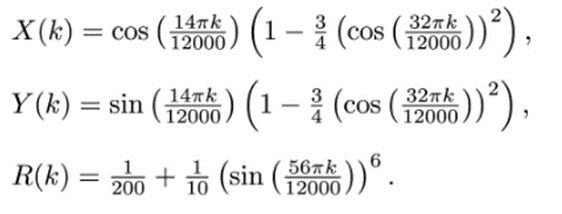

The computation to calculate the centre coordinates and radius of each circle is carried out in the programmable logic of the PYNQ-Z2 board. The design for this was realised using system generator to generate the IP core and IP interface document. The block diagram in system generator is shown below.

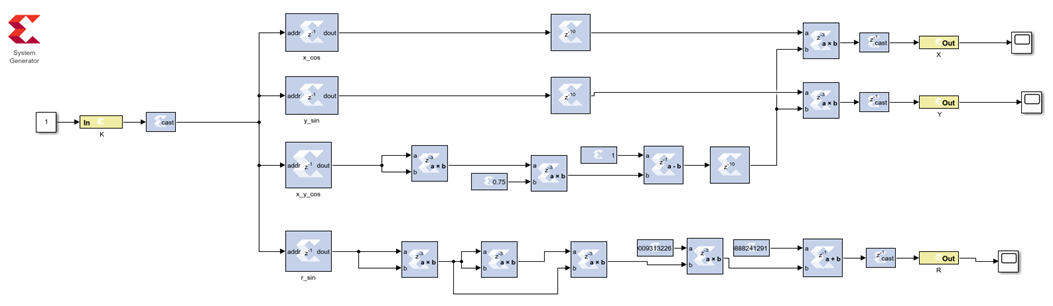

All the sine and cosine values are stored in lookup tables. These are addressed by the input variable k. The values obtained then go through the necessary computation of multiplication and addition/subtraction to achieve the functionality described in the above equations. Delay blocks are include to ensure equal path length between branches.

Vivado was then used to create the custom overlay using the IP from system generator. This created the following block diagram.

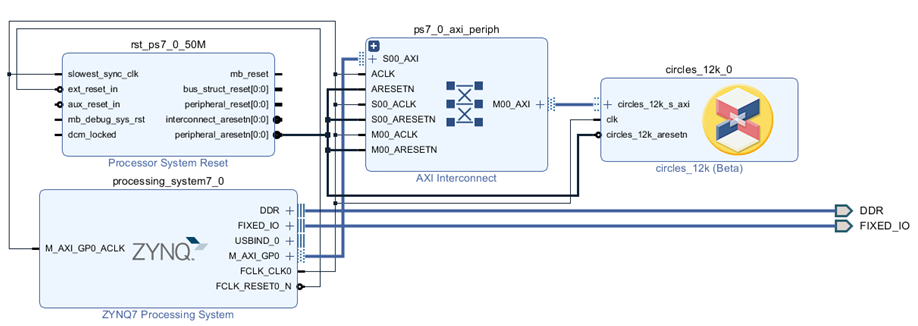

This was then used to generate the hardware handoff file and the bit file for the design, which are include in this project folder. The following code then declares a custom driver for the IP. This allows the processing system to read and write to the programmable logic efficiently.

In [3]:
from pynq import DefaultIP
class AddDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
    bindto = ['User_Company:SysGen:circles_12k:1.0']
    def getValues(self, k):
        self.write(0x00, k)
        return to_signedfract(self.read(0xC),32),to_signedfract(self.read(0x04),32),to_signedfract(self.read(0x08),32)

The custom overlay is then imported.

In [4]:
from pynq import Overlay
ol = Overlay("Circles12k_wrapper.bit");

In [5]:
circles_12K = ol.circles_12k_0

The following function obtains the circle values and plots them on a graph. The colour of the circles is gradually changed throughout the loop iteration. PuBuGn and BuPu colour codes are used here. Feel free to change these before you call the function. The following colour code options are available:

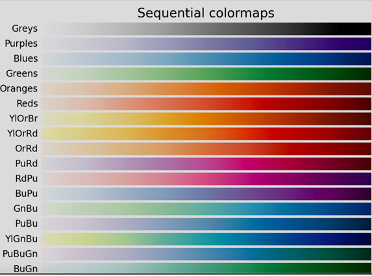

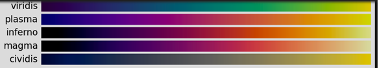

Call the function. Please be aware the run time for the function is about 5 mins due to the demanding nature of plotting 12,000 circles using the PYNQ-Z2 processor. You can reduce the dpi in the above function to marginally reduce this.

In [6]:
def plot_values():
    figure, axes = plt.subplots(dpi = 200)    
    for i in range(1, 12000):
        
        if i <= 7000:
            colour_grad = plt.cm.PuBuGn (i/7000)
        else:
            colour_grad = plt.cm.BuPu((i-7000)/7000)
        X,Y,R = circles_12K.getValues(i)
        axes.add_artist(plt.Circle((X,Y),R,fill=False, linewidth = 0.1, color = colour_grad))
    plt.xlim(-0.7, 0.7)
    plt.ylim(-0.7, 0.7)
    axes.axis('off')
    axes.set_aspect(1)
    plt.show()  
    return

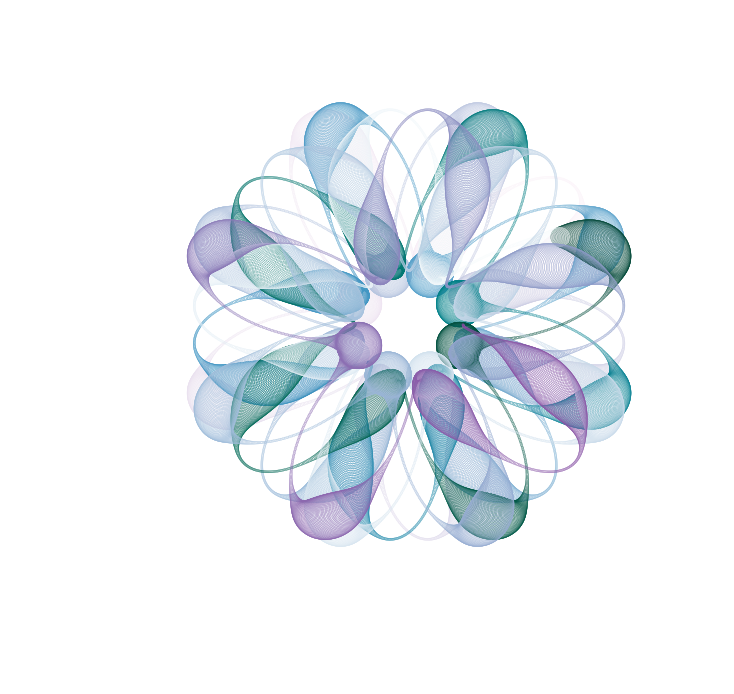

In [7]:
plot_values(); 

Although the run time for the overall function is incredibly long. The hardware carries out the computation very quickly. The run time to obtain all the values from the programmable logic is around 3 seconds, as demonstrated in the code below.

In [8]:
import time
start_time = time.time()
#Programmable Logic Speed Test
for i in range(1,12000):
    L,M,N =0,0,0
    L,M,N = circles_12K.getValues(i);
end_time = time.time()   
duration = end_time - start_time
print("Function took", duration, "seconds to run.")

Function took 2.622267484664917 seconds to run.
